In [1]:
!pip install progressbar2

# US-Segmentation with UNet

In [17]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [18]:
files = tf.keras.utils.get_file('data', origin='https://s5.uupload.ir/files/sepehrglst/data.zip', extract=True, cache_dir='.', cache_subdir='data')
print(files)

  2621440/453097340 [..............................] - ETA: 21:46

KeyboardInterrupt: 

In [19]:
from os import path

def read_info(patient, view = '2CH'):
    info_file_name = 'Info_'+view+'.cfg'
    info_file_path = path.join(patient, info_file_name)
    
    def remove_newline(line):
        return line[:-1]
    
    def keyvalue_pair(data):
        [key, value_str] = data.split(':')
        value_str = value_str.strip()
        return [key, value_str]
    
    with open(info_file_path, 'r') as file:
        patient_data = dict()
        info_string = file.readlines()
        info_string = list(map(remove_newline, info_string))
        info = list(map(keyvalue_pair, info_string))
        patient_data.update({'ed':float(info[0][1])})
        patient_data.update({'es':float(info[1][1])})
        patient_data.update({'nframe':int(info[2][1])})
        patient_data.update({'sex':info[3][1]})
        patient_data.update({'age':int(info[4][1])})
        patient_data.update({'image_quality':info[5][1]})
        patient_data.update({'lvedv':float(info[6][1])})
        patient_data.update({'lvesv':float(info[7][1])})
        patient_data.update({'lvef':float(info[8][1])})
        patient_data.update({'view':view})
        
        
    return patient_data

In [25]:
from glob import glob
import pandas as pd
import progressbar

patients = glob(r'data/datasets/training/*')

patient_db = list()
with progressbar.ProgressBar(max_value=len(patients)) as bar:
  for step, patient in enumerate(patients):
      patient_data = read_info(patient)
      patient_db.append(patient_data)
      patient_data = read_info(patient, view='4CH')
      patient_db.append(patient_data)
      bar.update(step)
    
patient_db = pd.DataFrame(patient_db)
patient_db

  0% (0 of 400) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (6 of 400) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00
  2% (11 of 400) |                       | Elapsed Time: 0:00:00 ETA:   0:00:05
  4% (16 of 400) |                       | Elapsed Time: 0:00:00 ETA:   0:00:05
  5% (21 of 400) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05
  6% (26 of 400) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:05
  7% (31 of 400) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:06
  9% (36 of 400) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06
 10% (41 of 400) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06
 11% (46 of 400) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06
 12% (51 of 400) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:06
 14% (56 of 400) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:06
 15% (60 of 400) |###                   

,ed,es,nframe,sex,age,image_quality,lvedv,lvesv,lvef,view
0,1.0,18.0,18,F,56,Good,94.0,34.6,63.2,2CH
1,1.0,20.0,20,F,56,Good,94.0,34.6,63.2,4CH
2,1.0,17.0,17,M,55,Medium,119.1,60.3,49.4,2CH
3,1.0,15.0,15,M,55,Medium,119.1,60.3,49.4,4CH
4,1.0,17.0,17,F,36,Good,105.7,47.1,55.4,2CH
...,...,...,...,...,...,...,...,...,...,...
795,1.0,22.0,22,M,68,Medium,51.8,12.0,76.8,4CH
796,1.0,16.0,16,F,75,Medium,78.4,25.5,67.5,2CH
797,1.0,18.0,18,F,75,Good,78.4,25.5,67.5,4CH
798,1.0,15.0,15,F,74,Good,89.1,50.4,43.4,2CH


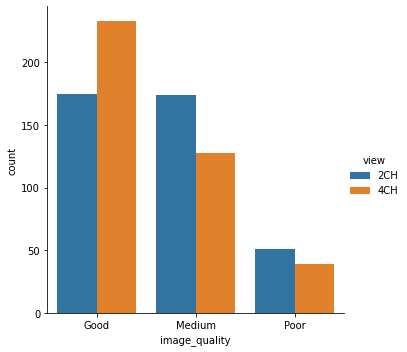

In [26]:
import seaborn as sns

sns.catplot(data=patient_db, x='image_quality', kind='count', hue='view')

## Prepare the data

### Load data

In [9]:
%pip install tensorflow-io

In [27]:
import tensorflow as tf
import tensorflow_io as tfio

import matplotlib.pyplot as plt

In [28]:
from glob import glob
from os import path


def isimage(fileaddress):
    filename = path.basename(fileaddress).split('.')[0]
    if filename.endswith('gt') or filename.endswith('sequence'):
        return False
    else:
        return True

def is2ch_view(fileaddress):
    filename = path.basename(fileaddress)
    view = filename.split('_')[1]
    if view=='2CH':
        return True
    else:
        return False

def issequence(fileaddress):
    filename = path.basename(fileaddress).split('.')[0]
    if filename.endswith('sequence'):
        return True


In [29]:
TRAIN_DATASET_PATH = r'data/datasets/training'
VALIDATION_DATASET_PATH = r'data/datasets/validation'


path_structure = path.join(TRAIN_DATASET_PATH, r'*/*.raw')
file_paths = glob(path_structure)
train_images = list(filter(isimage, file_paths))
sequences = list(filter(issequence, file_paths))

path_structure = path.join(VALIDATION_DATASET_PATH, r'*/*.raw')
file_paths = glob(path_structure)
validation_images = list(filter(isimage, file_paths))
sequences.extend(list(filter(issequence, file_paths)))

In [37]:
@tf.function
def tf_read_raw_image(image_path, target_size=(128, 128)):
    imgfile = tf.io.read_file(image_path)
    img_fileadd = tf.strings.split(image_path, '.')[0]
    mhd_fileadd = tf.strings.join([img_fileadd, '.mhd'])
    img_dims = tf_read_mhd_data(mhd_fileadd)
    def correct_dims(dims):
        dims_correct = [dims[1], dims[0], dims[2]]
        dims_correct = tf.stack(dims_correct, axis=0)
        return dims_correct
    imgbytes = tf.io.decode_raw(imgfile, out_type=tf.uint8)
    img = tf.reshape(imgbytes, correct_dims(img_dims))
    img = tf.cast(img, tf.float32)
    img = (img - tf.math.reduce_min(img))/(tf.math.reduce_max(img) - tf.math.reduce_min(img))
    img = tf.image.resize(img, target_size)
    img = tf.repeat(img, 3, axis=2)
    return img


@tf.function
def tf_read_mask_image(image_path, target_size=(128, 128)):
    imgfile = tf.io.read_file(image_path)
    img_fileadd = tf.strings.split(image_path, '.')[0]
    mhd_fileadd = tf.strings.join([img_fileadd, '.mhd'])
    img_dims = tf_read_mhd_data(mhd_fileadd)
    def correct_dims(dims):
        dims_correct = [dims[1], dims[0], dims[2]]
        dims_correct = tf.stack(dims_correct, axis=0)
        return dims_correct
    imgbytes = tf.io.decode_raw(imgfile, out_type=tf.uint8)
    img = tf.reshape(imgbytes, correct_dims(img_dims))
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img = tf.cast(img, tf.uint8)
    img = tf.squeeze(img)
    return tf.one_hot(img, depth=4)


@tf.function
def tf_read_mhd_data(mhd_address):
    file_metadata_string = tf.io.read_file(mhd_address)
    print(file_metadata_string)
    # Complete this function later
    
@tf.function
def tf_read_image_and_mask(input_address):
    image = tf_read_raw_image(input_address)
    mask_fileadd = tf.strings.split(input_address, '.')[0]
    mask_fileadd = tf.strings.join([mask_fileadd, '_gt.raw'])
    mask_fileadd = tf.squeeze(mask_fileadd)
    mask = tf_read_mask_image(mask_fileadd)
    return (image, mask)


@tf.function
def tf_read_ae_data(input_address):
    mask_fileadd = tf.strings.split(input_address, '.')[0]
    mask_fileadd = tf.strings.join([mask_fileadd, '_gt.raw'])
    mask_fileadd = tf.squeeze(mask_fileadd)
    mask = tf_read_mask_image(mask_fileadd)
    return (mask, mask)

@tf.function
def tf_read_mhd_data(mhd_address):
    mhd_data_file = tf.io.read_file(mhd_address)
    mhd_lines = tf.strings.split(mhd_data_file, '\n')
    mhd_lines = tf.strings.split(mhd_lines, ' = ')
    dimsize = mhd_lines[10][1]
    dimsize = tf.strings.split(dimsize, ' ')
    dimsize = tf.boolean_mask(dimsize, mask=tf.math.logical_not(tf.math.equal(dimsize, b'')))
    #dimsize_new = tf.map_fn(tf.strings.to_number, dimsize)
    dimsize = tf.strings.to_number(dimsize)
    dimsize = tf.cast(dimsize, tf.int32)
    #element_number_of_channels = tf.strings.to_number(mhd_lines[11][1])
    return dimsize
    

train_ds_path = tf.data.Dataset.from_tensor_slices(train_images)
train_ae_ds = train_ds_path.map(tf_read_ae_data)
train_ds = train_ds_path.map(tf_read_image_and_mask)

validation_ds_path = tf.data.Dataset.from_tensor_slices(validation_images)
validation_ae_ds = validation_ds_path.map(tf_read_ae_data)
validation_ds = validation_ds_path.map(tf_read_image_and_mask)

(128, 128, 3)
(128, 128, 3)


InvalidArgumentError: slice index 3 of dimension 2 out of bounds. [Op:StridedSlice] name: strided_slice/

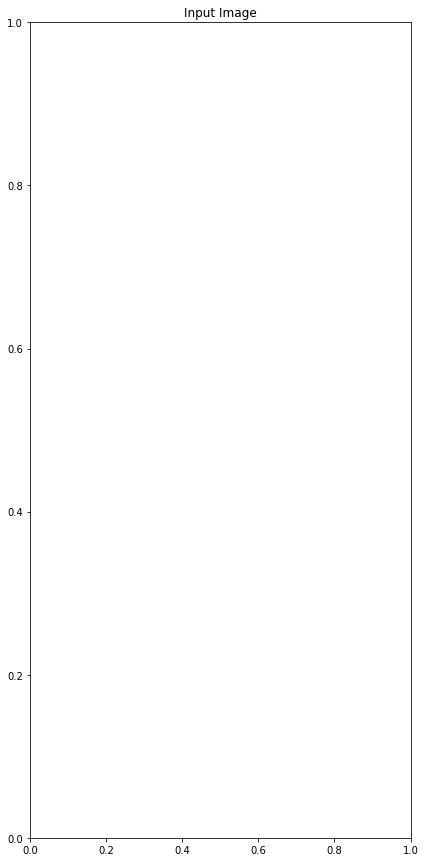

In [47]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        print(display_list[i].shape)
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.squeeze(display_list[i][:, :, 3]))
        plt.axis('off')
    plt.show()


for images, masks in train_ds.take(1):
    print(images.shape)
    display([images, masks])

In [48]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000


train_ds = (
    train_ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


train_ae_ds = (
    train_ae_ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


validation_ds = validation_ds.batch(BATCH_SIZE)
validation_ae_ds = validation_ae_ds.batch(BATCH_SIZE)

In [17]:
train_ds

<PrefetchDataset shapes: ((None, 128, 128, None), (None, 128, 128, None)), types: (tf.float32, tf.float32)>

In [18]:
%pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ez5r64yl
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ez5r64yl
  Resolved https://github.com/tensorflow/examples.git to commit a9265a997d0410c431a292e3553646b3b655ea1f


In [19]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Segmentation Model

In this part we will try to exaclty define the U-Net model according to the article. As described in the article, the first part of our model is VGG-Net and the synthesizer part is 3D U-Net.


VGG-Net Article:
>K. Simonyan and A. Zisserman. (Sep. 2014). “Very deep convolutional networks for large-scale image recognition.” [Online]. Available: https://arxiv.org/abs/1409.1556

3D U-Net:
>O. Ronneberger, P. Fischer, and T. Brox, “U-net: Convolutional networks for biomedical image segmentation,” in Proc. Int. Conf. MICCAI, 2015, pp. 234–241.

In [23]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape=[128, 128, 3], include_top=False, weights='data/datasets/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


layer_names = [
    'block1_conv2',
    'block2_conv2',
    'block3_conv3',
    'block4_conv3'
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [24]:
down_stack.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [25]:
from tensorflow_examples.models.pix2pix import pix2pix

with tf.device('/GPU:0'):
    up_stack = [
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

In [26]:
def unet_model(output_channels:int):
    
    with tf.device('/GPU:0'):
        inputs = tf.keras.layers.Input(shape=[128, 128, 3])

        # Downsampling through the model
        skips = down_stack(inputs)
        x = skips[-1]
        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])

        # This is the last layer of the model
        last = tf.keras.layers.Conv2DTranspose(
            filters=output_channels, kernel_size=3, strides=2,
            padding='same')  #64x64 -> 128x128

        x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [20]:
from argparse import ArgumentError
from email.mime import message
import tensorflow as tf
from metrics import DiceCoefficient

In [32]:
from tensorflow.keras.models import load_model


# OUTPUT_CLASSES = 4

# usnet = unet_model(output_channels=OUTPUT_CLASSES)
usnet = load_model('usnet03', compile=False)
usnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[
                       DiceCoefficient(class_id=1, name = 'dice_class_1'),
                       DiceCoefficient(class_id=2, name = 'dice_class_2'),
                       DiceCoefficient(class_id=3, name = 'dice_class_3')
                       ])

In [33]:
usnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 128, 128, 64 7635264     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 128)  590336      model[0][3]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 384)  0           sequential[0][0]                 
                                                                 model[0][2]                

In [31]:
tf.keras.utils.plot_model(usnet)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


(128, 128, 1)


2022-03-04 15:00:24.738363: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-03-04 15:00:26.730828: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-04 15:00:26.732268: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-04 15:00:26.732324: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-03-04 15:00:26.734069: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-04 15:00:26.734315: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


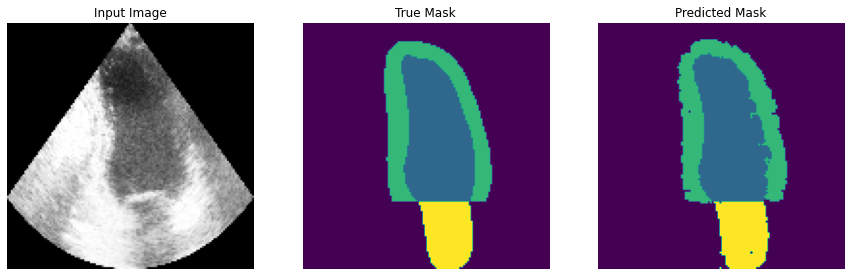

In [23]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = usnet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        print(masks.shape)
        display([images, masks,
                 create_mask(usnet.predict(images[tf.newaxis, ...]))])
    
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


from tensorflow.keras.callbacks import TensorBoard


tb = TensorBoard('logs/exp03')
callbacks = [tb, DisplayCallback()]

(128, 128, 1)


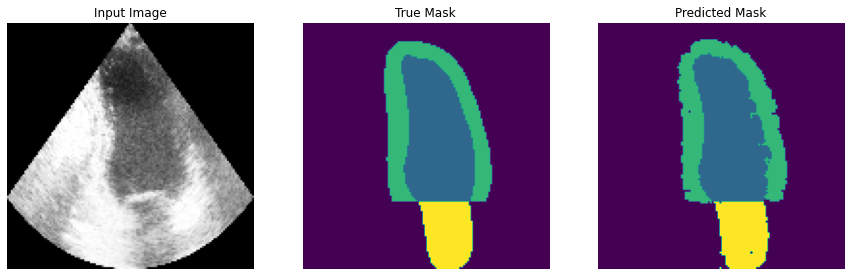


Sample Prediction after epoch 100



In [34]:
EPOCHS = 100

model_history = usnet.fit(train_ds, epochs=EPOCHS,
                          callbacks=callbacks, validation_data = validation_ds)

In [35]:
usnet.save('usnet03')

2022-03-03 19:01:09.244286: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: usnet03/assets


In [30]:

def read_raw_image(image_path, target_size=(128, 128)):
    imgfile = tf.io.read_file(image_path)
    img_fileadd = tf.strings.split(image_path, '.')[0]
    mhd_fileadd = tf.strings.join([img_fileadd, '.mhd'])
    img_dims = read_mhd_data(mhd_fileadd)
    def correct_dims(dims):
        dims_correct = [dims[1], dims[0], dims[2]]
        dims_correct = tf.stack(dims_correct, axis=0)
        return dims_correct
    imgbytes = tf.io.decode_raw(imgfile, out_type=tf.uint8)
    img = tf.reshape(imgbytes, correct_dims(img_dims))
    img = tf.cast(img, tf.float32)
    img = (img - tf.math.reduce_min(img))/(tf.math.reduce_max(img) - tf.math.reduce_min(img))
    if target_size:
        img = tf.image.resize(img, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img = tf.repeat(img, 3, axis=2)
    return img



def read_mask_image(image_path, target_size=(128, 128)):
    imgfile = tf.io.read_file(image_path)
    img_fileadd = tf.strings.split(image_path, '.')[0]
    mhd_fileadd = tf.strings.join([img_fileadd, '.mhd'])
    img_dims = read_mhd_data(mhd_fileadd)
    def correct_dims(dims):
        dims_correct = [dims[1], dims[0], dims[2]]
        dims_correct = tf.stack(dims_correct, axis=0)
        return dims_correct
    imgbytes = tf.io.decode_raw(imgfile, out_type=tf.uint8)
    img = tf.reshape(imgbytes, correct_dims(img_dims))
    img = tf.cast(img, tf.float32)
    if target_size:
        img = tf.image.resize(img, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img



def read_mhd_data(mhd_address):
    file_metadata_string = tf.io.read_file(mhd_address)
    print(file_metadata_string)
    # Complete this function later
    

def read_image_and_mask(input_address, target_size=None):
    image = read_raw_image(input_address, target_size=target_size)
    mask_fileadd = tf.strings.split(input_address, '.')[0]
    mask_fileadd = tf.strings.join([mask_fileadd, '_gt.raw'])
    mask_fileadd = tf.squeeze(mask_fileadd)
    mask = read_mask_image(mask_fileadd, target_size=target_size)
    return (image, mask)


def read_mhd_data(mhd_address):
    mhd_data_file = tf.io.read_file(mhd_address)
    mhd_lines = tf.strings.split(mhd_data_file, '\n')
    mhd_lines = tf.strings.split(mhd_lines, ' = ')
    dimsize = mhd_lines[10][1]
    dimsize = tf.strings.split(dimsize, ' ')
    dimsize = tf.boolean_mask(dimsize, mask=tf.math.logical_not(tf.math.equal(dimsize, b'')))
    #dimsize_new = tf.map_fn(tf.strings.to_number, dimsize)
    dimsize = tf.strings.to_number(dimsize)
    dimsize = tf.cast(dimsize, tf.int32)
    #element_number_of_channels = tf.strings.to_number(mhd_lines[11][1])
    return dimsize

### Analyze model

Now let's analyze our model. In order to do so, we will plot and see model performance, data by data and save them.

In [25]:
path_structure = path.join(TRAIN_DATASET_PATH, r'*/*.raw')
file_paths = glob(path_structure)
train_images = list(filter(isimage, file_paths))
train_images


test_dice = DiceCoefficient(class_id=1, name = 'dice_class_1')


with progressbar.ProgressBar(max_value=len(train_images)) as bar:
    for step, image_file in enumerate(train_images):
        test_dice.reset_state()
        image, mask = read_image_and_mask(image_file)
        name = path.basename(image_file).split('.')[0]
        model_output = usnet.predict(image[tf.newaxis, ...])
        test_dice.update_state(mask, model_output)
        pred_mask = create_mask(model_output)
        plt.figure(figsize=(9, 6), dpi=300)
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1, 3, 2)
        plt.xticks([])
        plt.yticks([]) 
        plt.imshow(image)
        plt.imshow(mask, alpha=0.3)
        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(pred_mask, alpha=0.3)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'dice lv = {test_dice.result().numpy()}')
        plt.savefig(path.join('train_images', name+'.jpg'))
        plt.close()
        bar.update(step)

100% (1600 of 1600) |####################| Elapsed Time: 0:16:52 Time:  0:16:52


In [ ]:
!tar -cvf train_images.tar train_images/

In [28]:
path_structure = path.join(VALIDATION_DATASET_PATH, r'*/*.raw')
file_paths = glob(path_structure)
valid_images = list(filter(isimage, file_paths))
valid_images


test_dice = DiceCoefficient(class_id=1, name = 'dice_class_1')


with progressbar.ProgressBar(max_value=len(valid_images)) as bar:
    for step, image_file in enumerate(valid_images):
        test_dice.reset_state()
        image, mask = read_image_and_mask(image_file)
        name = path.basename(image_file).split('.')[0]
        model_output = model.predict(image[tf.newaxis, ...])
        test_dice.update_state(mask, model_output)
        pred_mask = create_mask(model_output)
        plt.figure(figsize=(9, 6), dpi=300)
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1, 3, 2)
        plt.xticks([])
        plt.yticks([]) 
        plt.imshow(image)
        plt.imshow(mask, alpha=0.3)
        plt.subplot(1, 3, 3)
        plt.imshow(image)
        plt.imshow(pred_mask, alpha=0.3)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'dice lv = {test_dice.result().numpy()}')
        plt.savefig(path.join('valid_images', name+'.jpg'))
        plt.close()
        bar.update(step)

100% (200 of 200) |######################| Elapsed Time: 0:02:38 Time:  0:02:38


In [ ]:
!tar -cvf valid_images.tar valid_images/

In [ ]:
with progressbar.ProgressBar(max_value=len(valid_images)) as bar:
    for step, image_file in enumerate(valid_images):
        test_dice.reset_state()
        image, mask = read_image_and_mask(image_file, target_size=(128, 128))
        name = path.basename(image_file).split('.')[0]
        model_output = model.predict(image[tf.newaxis, ...])
        test_dice.update_state(mask, model_output)
        if test_dice.result().numpy()<0.7:
            image, mask = read_image_and_mask(image_file)
            plt.figure(dpi=300)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.savefig(path.join('low_dice_images', name+'.png'))
        bar.update(step)

In [ ]:
!tar -cvf low_dice_images.tar low_dice_images/

In [ ]:
!tar -cvf logs.tar logs/

In [ ]:
!tar -cvf usnet03.tar usnet03/

## Add Auto-Encoder


In this part we will create an auto-encoder and add it's loss as a regularization term to our network

In [49]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Model

def build_encoder(output_dim=64, input_dim=(128, 128, 4)):
    label_map = Input(input_dim, name='label_map_in')
    e = Conv2D(4, 3, activation='relu', padding='same')(label_map)
    e = MaxPool2D(2)(e)
    e = Conv2D(8, 3, activation='relu', padding='same')(e)
    e = MaxPool2D(2)(e)
    e = Conv2D(16, 3, activation='relu', padding='same')(e)
    e = MaxPool2D(2)(e)
    e = Flatten()(e)
    codes = Dense(64, activation='sigmoid')(e)
    return Model(inputs=label_map, outputs=codes)

encoder = build_encoder()
encoder.summary()
    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
label_map_in (InputLayer)    [(None, 128, 128, 4)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 4)       148       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0     

In [50]:
from tensorflow.keras.layers import Conv2DTranspose, Reshape, UpSampling2D

def build_decoder(input_dims=64):
    codes = Input(input_dims)
    d = Dense(16*16*16, activation='relu')(codes)
    d = Reshape((16, 16, 16))(d)
    d = UpSampling2D((2, 2))(d)
    d = Conv2D(16, 2, padding='same')(d)
    d = UpSampling2D((2, 2))(d)
    d = Conv2D(8, 2, padding='same')(d)
    d = UpSampling2D((2, 2))(d)
    d = Conv2D(4, 2, padding='same')(d)
    return Model(inputs=codes, outputs=d)

decoder = build_decoder()
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              266240    
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 16)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        1040      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 8)         520 

In [51]:
ae_input = Input((128, 128, 4))
codes = encoder(ae_input)
rconst = decoder(codes)
ae_model = Model(inputs = ae_input, outputs=rconst)
ae_model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 4)]     0         
_________________________________________________________________
model (Functional)           (None, 64)                263820    
_________________________________________________________________
model_1 (Functional)         (None, 128, 128, 4)       267932    
Total params: 531,752
Trainable params: 531,752
Non-trainable params: 0
_________________________________________________________________


In [54]:
ae_model.compile(loss = tf.keras.losses.MeanAbsoluteError(), optimizer='adam')

ae_model.fit(train_ae_ds, epochs=5, validation_data=validation_ae_ds)

Epoch 1/5
25/25 [==============================] - 39s 695ms/step - loss: 0.2577 - val_loss: 0.2060
Epoch 2/5
25/25 [==============================] - 9s 349ms/step - loss: 0.1681 - val_loss: 0.1338
Epoch 3/5
25/25 [==============================] - 9s 351ms/step - loss: 0.1207 - val_loss: 0.1178
Epoch 4/5
25/25 [==============================] - 9s 363ms/step - loss: 0.1073 - val_loss: 0.1100
Epoch 5/5
25/25 [==============================] - 9s 349ms/step - loss: 0.0996 - val_loss: 0.1057


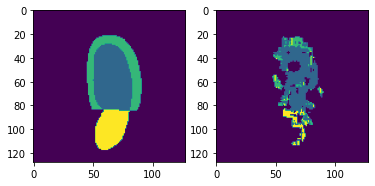

In [59]:
for image_in, image_tar in train_ae_ds.take(1):
    preds = ae_model.predict(image_in)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(tf.argmax(image_tar[2], axis=-1))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.argmax(preds[2], axis=-1))
    plt.show()